# Анализ и прогнозирование временных рядов. Оборот розничной торговли

## Загрузка данных

In [1]:
import pandas as pd # Работа с табличными данными и рядами
import numpy as np # Работа с массивами
import statsmodels.api as sm # Анализ и моделирование временных рядов
import seaborn as sns # Визуализация
import matplotlib.pyplot as plt # Визуализация

# Графики встраиваются в блокнот:
%matplotlib inline
sns.set() # Стиль графиков

Для обработки табличных данных в Python используется пакет pandas. С тем, как выполнять базовые операции с таблицами и рядами pandas, можно познакомиться по блокнотам в [этом репозитории](https://github.com/postlogist/python-ds/tree/master/pandas).

In [2]:
retail = pd.read_excel('retail.xlsx', # файл с данными
                       index_col='month',  # столбец 'month' нужно использовать как индекс
                       squeeze=True #нам нужен ряд, а не таблица
                      ) 

retail.index.freq='MS' # Уточнили частоту наблюдений - ежемесячно, для индекса используется 1й день месяца.
retail

month
1995-01-01      27.3
1995-02-01      28.1
1995-03-01      32.9
1995-04-01      33.4
1995-05-01      39.4
               ...  
2021-06-01    3189.0
2021-07-01    3288.8
2021-08-01    3419.4
2021-09-01    3391.8
2021-10-01    3462.4
Freq: MS, Name: RTRD_M, Length: 322, dtype: float64

Pandas поддерживает даты в качестве индекса, благодаря этому в этом пакете удобно обрабатывать временные ряды, т.к. выравнивание по дате, выполняется автоматически.

In [3]:
retail.index

DatetimeIndex(['1995-01-01', '1995-02-01', '1995-03-01', '1995-04-01',
               '1995-05-01', '1995-06-01', '1995-07-01', '1995-08-01',
               '1995-09-01', '1995-10-01',
               ...
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01'],
              dtype='datetime64[ns]', name='month', length=322, freq='MS')

Используя встроенные в pandas визуализации, посмотрим на данные. С визуализацией табличных данных в python можно познакомиться в [этом репозитории](https://github.com/postlogist/python-ds/tree/master/EDA)

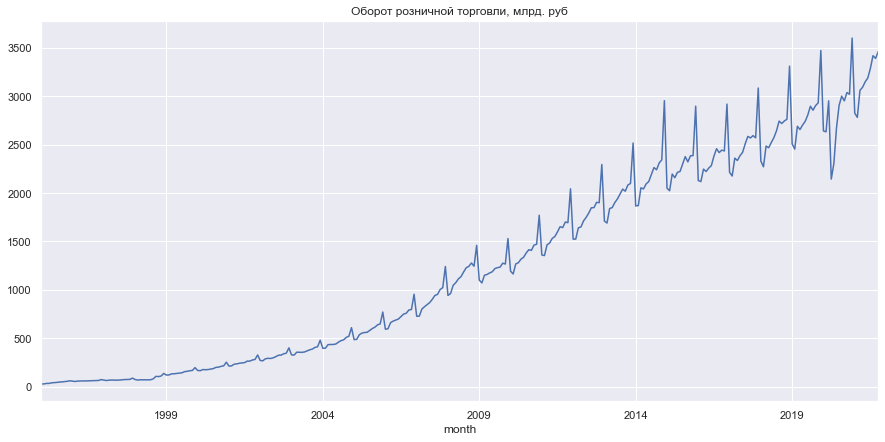

In [4]:
retail.plot(figsize=(15,7), title='Оборот розничной торговли, млрд. руб');

Данные есть за период с середины 1990-х. Для анализа возьмем последний период, когда закономерные компоненты ряда вели себя более-менее стабильно. Будем использовать данные с января 2010 года.

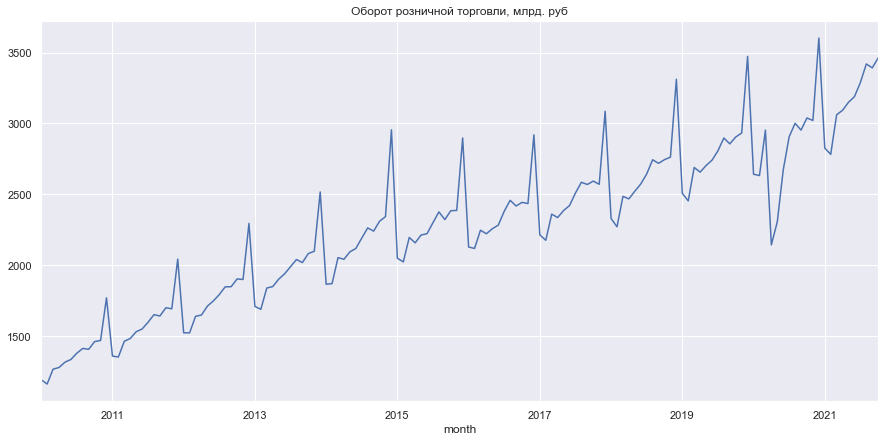

In [5]:
retail = retail['2010-01-01':] # в pandas можно задавать срезы по дате
retail.plot(figsize=(15,7), title='Оборот розничной торговли, млрд. руб');

На графике виден тренд и сезонность. Тип сезонности - мультипликативный.

## Сезонная декомпозиция для анализа структуры ряда

Для анализа структуры ряд разложим его на компоненты, используя функцию `seasonal_decompose` пакета statsmodels - [help](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). 

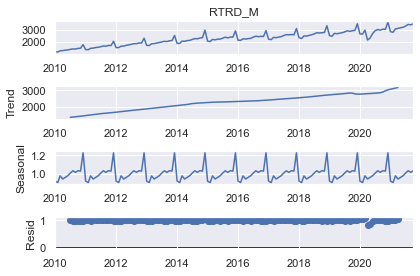

In [6]:
retail_d = sm.tsa.seasonal_decompose(retail, model='multiplicative')
retail_d.plot();

На этом графике компоненты видно плохо. Рассмотрим их отдельно.

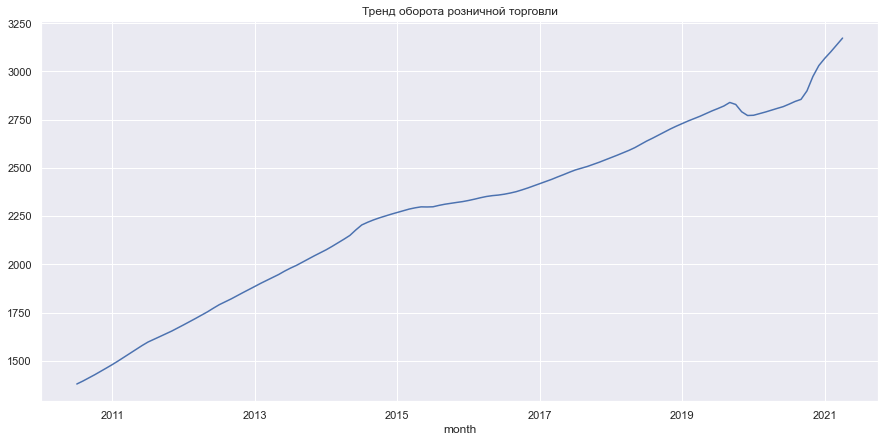

In [7]:
retail_d.trend.plot(figsize=(15,7),
                   title='Тренд оборота розничной торговли'); # Тренд

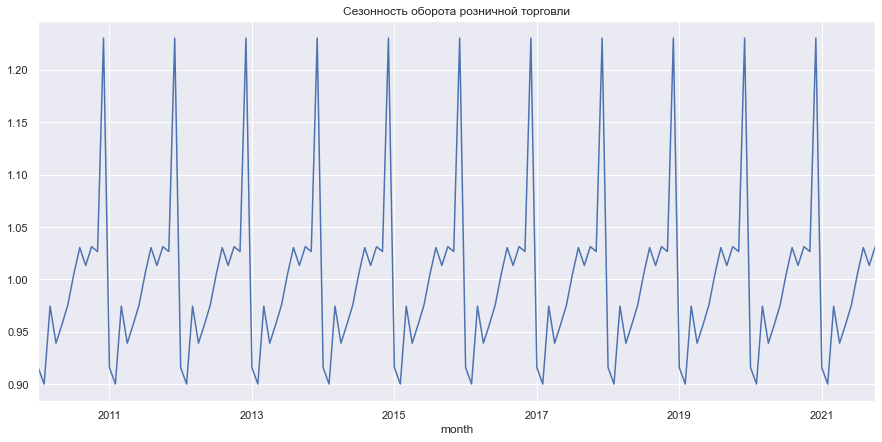

In [8]:
retail_d.seasonal.plot(figsize=(15,7),
                      title='Сезонность оборота розничной торговли'); # Сезонность

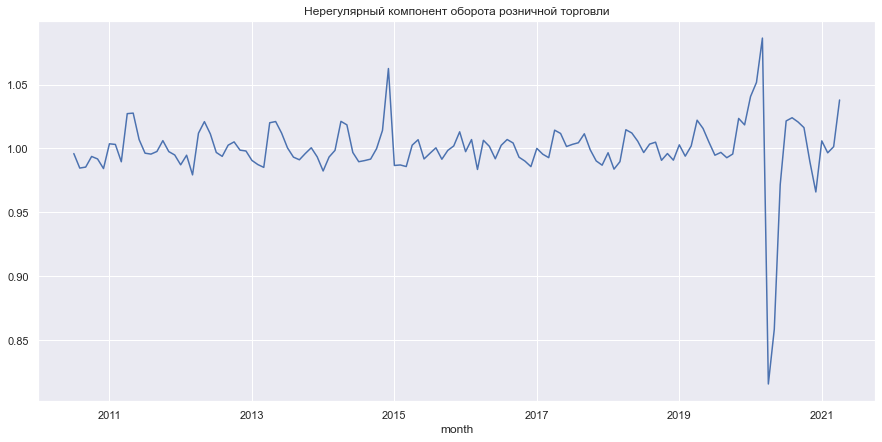

In [9]:
retail_d.resid.plot(figsize=(15,7),
                   title='Нерегулярный компонент оборота розничной торговли'); # Остаток

Сложив тренд и сезонность, получим модель ряда

In [10]:
retail_pred1 = retail_d.trend * retail_d.seasonal # Мы моделировали мультипликативную сезонность

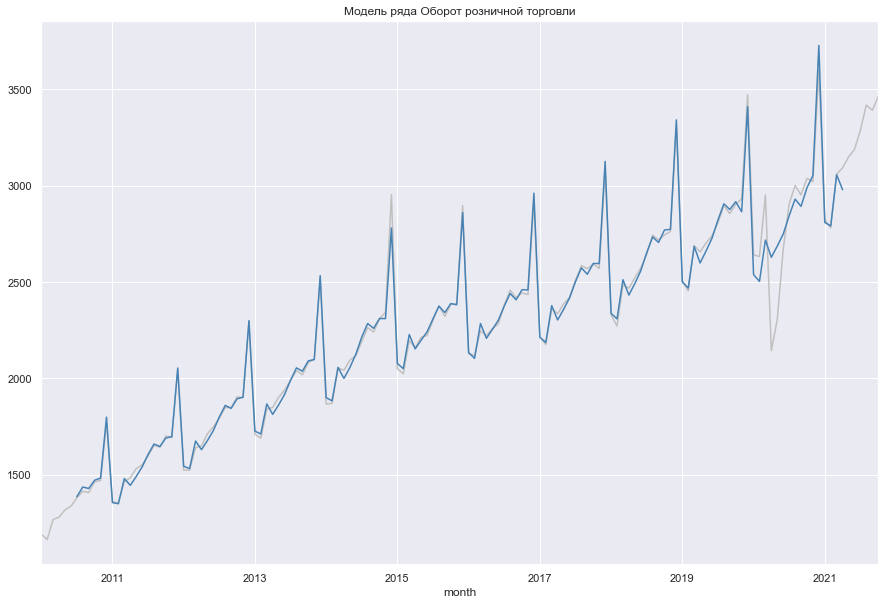

In [11]:
plt.subplots(figsize=(15, 10))
retail.plot(color='silver')
retail_pred1.plot(color='steelblue', title='Модель ряда Оборот розничной торговли');


В statsmodels есть еще одна визуализация, которая показывает сезонность - средние значения сезонного индекса для месяца и изменения сезонного индекса в разные годы.

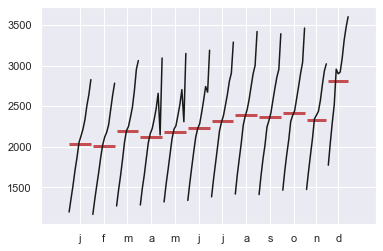

In [12]:
sm.graphics.tsa.month_plot(retail);

Еще один пример декомпозиции ряда с использованием сглаженного тренда - [STL-декомпозиция](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html). Этот способ позволяет также получать прогнозы на будущее.

## Моделирование

Полезные ресурсы и примеры:

https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html  
https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html  
https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/
https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/


Для проверки моделей разделим ряд на два подмножества, используя в качестве тестового множества последний год, а остальные данные - в качестве обучающего множества.

In [13]:
retail_train = retail[:'2020-10-01'] # Обучающее множество
retail_test = retail['2020-11-01':] # Тестовое множество

### Простое экспоненциальное сглаживание

Метод реализован с помощью класса [`SimpleExpSmoothing`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html) пакета statsmodels. 

См. также документацию на метод [`fit()`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.fit.html#statsmodels.tsa.holtwinters.SimpleExpSmoothing.fit)

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

Построим модель с заданной вручную константой сглаживания: $\alpha=0.1$.

In [15]:
retail_m_exp1 = SimpleExpSmoothing(retail_train, 
                               initialization_method="heuristic"
                              ).fit(smoothing_level=0.1, # Задаем константу сглаживания 0.1
                                    optimized=False)

In [16]:
retail_f_exp1 = retail_m_exp1.forecast(12) # прогноз на 12 месяцев
retail_fit_exp1 = retail_m_exp1.fittedvalues # прогноз модели в историческом периоде

Построим еще одну модель с автоподбором константы сглаживания.

In [17]:
retail_m_exp2 = SimpleExpSmoothing(retail_train, 
                               initialization_method="heuristic"
                              ).fit(optimized=True # В этой модели константа подбирается автоматически
                                   )

retail_f_exp2 = retail_m_exp2.forecast(12)
retail_fit_exp2 = retail_m_exp2.fittedvalues

retail_m_exp2.params_formatted # Параметры модели


,name,param,optimized
smoothing_level,alpha,0.262294,True
initial_level,l.0,1265.518318,True


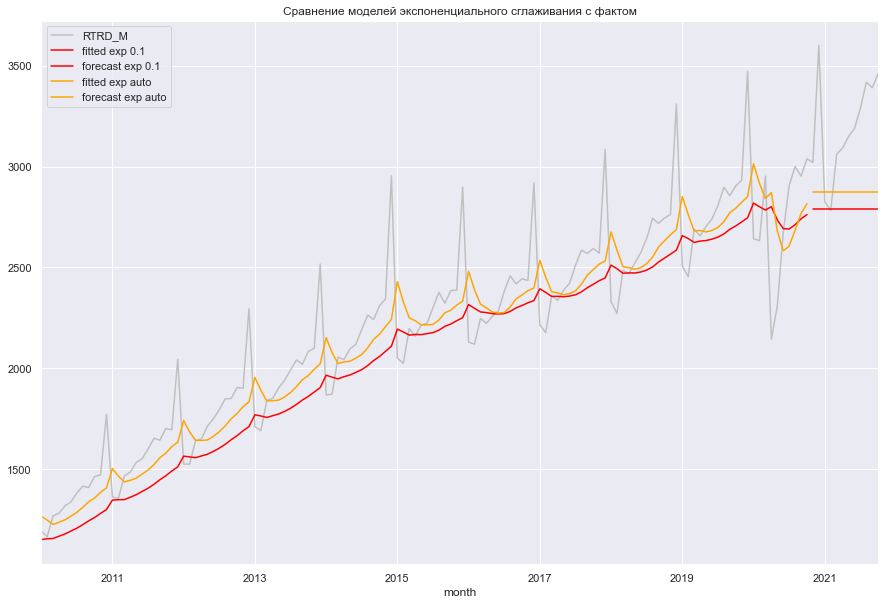

In [18]:
plt.subplots(figsize=(15, 10))
retail.plot(color='silver')
retail_fit_exp1.plot(label='fitted exp 0.1', color='red')
retail_f_exp1.plot(label='forecast exp 0.1', color='red')
retail_fit_exp2.plot(label='fitted exp auto', color='orange')
retail_f_exp2.plot(label='forecast exp auto', color='orange')
plt.title('Сравнение моделей экспоненциального сглаживания с фактом')
plt.legend();

## Метод Хольта

Метод Хольта реализован в классе [`ExponentialSmoothing`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html)

В statsmodels есть также [альтернативная реализация метода Хольта](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.Holt.html?highlight=holt).


In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Модель с константами сглаживания $\alpha=0.1$, $\beta=0.1$

In [20]:
retail_m_holt1 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='additive', # используется аддитивный тренд (линейный)
                               seasonal=None                                 
                              ).fit(smoothing_level=0.1, smoothing_trend=0.1, optimized=False)

In [21]:
retail_fit_holt1 = retail_m_holt1.fittedvalues
retail_f_holt1 = retail_m_holt1.forecast(12)


Модель с автоподбором констант

In [22]:
retail_m_holt2 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='additive',
                               seasonal=None                                 
                              ).fit(optimized=True)
retail_m_holt2.params_formatted

,name,param,optimized
smoothing_level,alpha,0.099977,True
smoothing_trend,beta,0.076923,True
initial_level,l.0,1150.402826,True
initial_trend,b.0,19.968754,True


In [23]:
retail_fit_holt2 = retail_m_holt2.fittedvalues
retail_f_holt2 = retail_m_holt2.forecast(12)

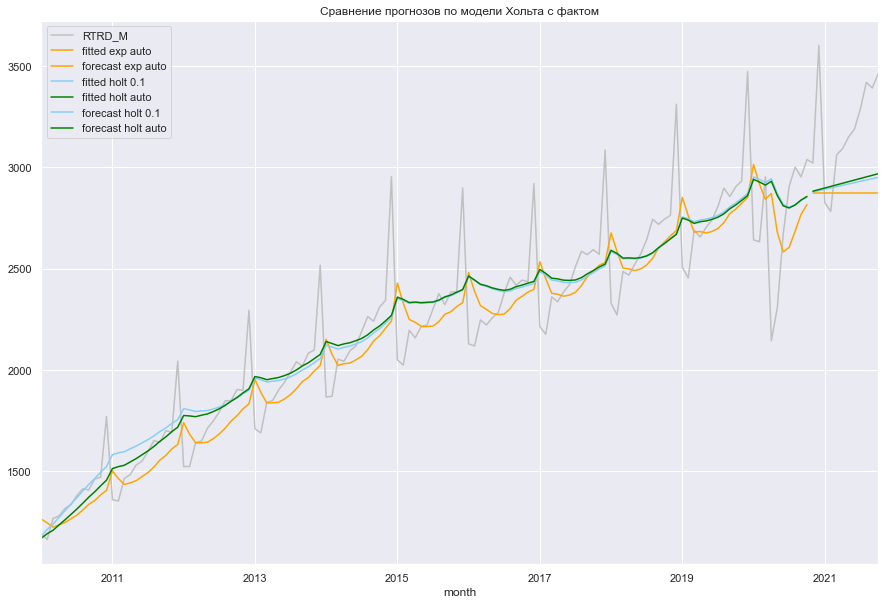

In [24]:
plt.subplots(figsize=(15, 10))
retail.plot(color='silver')
retail_fit_exp2.plot(label='fitted exp auto', color='orange')
retail_f_exp2.plot(label='forecast exp auto', color='orange')
retail_fit_holt1.plot(label='fitted holt 0.1', color='lightskyblue')
retail_fit_holt2.plot(label='fitted holt auto', color='green')
retail_f_holt1.plot(label='forecast holt 0.1', color='lightskyblue')
retail_f_holt2.plot(label='forecast holt auto', color='green')
plt.title('Сравнение прогнозов по модели Хольта с фактом')
plt.legend();

### Метод Винтерса

Метод Винтерса реализован с помощью класса [`ExponentialSmoothing`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html)

Модель с константами сглаживания $\alpha=0.1$, $\beta=0.1$, $\gamma=0.1$.

In [25]:
retail_m_winters1 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='additive', #аддитивный тренд
                               seasonal='multiplicative', #мультипликативная сезонность                                  
                              ).fit(smoothing_level=0.1, smoothing_trend=0.1, smoothing_seasonal=0.1,
                                    optimized=False)

In [26]:
retail_fit_winters1 = retail_m_winters1.fittedvalues
retail_f_winters1 = retail_m_winters1.forecast(12)

Модель с автоподбором констант.

In [27]:
retail_m_winters2 = ExponentialSmoothing(retail_train, 
                               initialization_method="heuristic", 
                               trend='additive',
                               seasonal='multiplicative'                                 
                              ).fit(optimized=True)
retail_m_winters2.params_formatted

,name,param,optimized
smoothing_level,alpha,0.606390,True
smoothing_trend,beta,0.000287,True
smoothing_seasonal,gamma,0.393049,True
initial_level,l.0,1356.386060,True
initial_trend,b.0,11.993529,True
initial_seasons.0,s.0,0.912640,True
initial_seasons.1,s.1,0.898011,True
initial_seasons.2,s.2,0.967478,True
initial_seasons.3,s.3,0.971834,True
initial_seasons.4,s.4,0.999790,True


In [28]:
retail_fit_winters2 = retail_m_winters2.fittedvalues
retail_f_winters2 = retail_m_winters2.forecast(12)

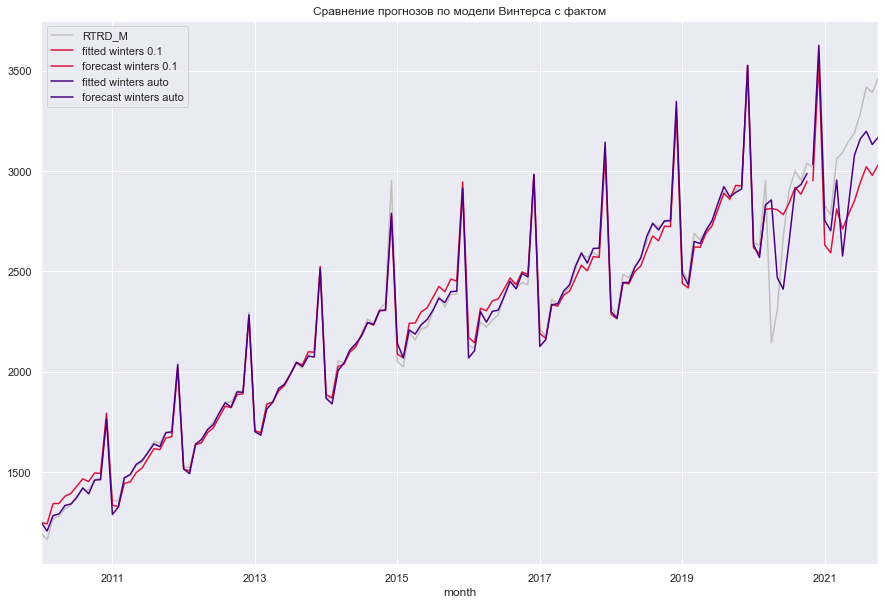

In [29]:
plt.subplots(figsize=(15, 10))
retail.plot(color='silver')
retail_fit_winters1.plot(label='fitted winters 0.1', color='crimson')
retail_f_winters1.plot(label='forecast winters 0.1', color='crimson')
retail_fit_winters2.plot(label='fitted winters auto', color='indigo')
retail_f_winters2.plot(label='forecast winters auto', color='indigo')
plt.title('Сравнение прогнозов по модели Винтерса с фактом')

plt.legend();

## Расчет ошибок

В statsmodels реализованы несколько [показателей ошибки прогноза](https://www.statsmodels.org/dev/tools.html?highlight=eval#measure-for-fit-performance-eval-measures)

In [30]:
from statsmodels.tools.eval_measures import rmse, bias, meanabs

In [31]:
rmse(retail_test, retail_f_winters2)

227.55921592940487

In [32]:
bias(retail_test, retail_f_winters2)

172.14326389492666

In [33]:
meanabs(retail_f_winters2, retail_test)

178.38298027590963

Однако, среди реализованных показателей нет MAPE, поэтому реализуем функцию для расчета MAPE самостоятельно:

In [34]:
mape = lambda actuals, forecast : ((actuals - forecast).abs() / actuals).mean()

In [35]:
mape(retail_test, retail_f_winters2)

0.055568117686140533

Для удобства сравнения моделей, создадим свою функцию, которая принимает ряды с фактом и прогнозом и возвращает показатели ошибки в табличном виде:

In [36]:
def metrics(model, actuals, forecast):
    return pd.DataFrame({'model' : model, 
                         'mape' : mape(actuals, forecast),
                         'rmse' : rmse(actuals, forecast),
                         'bias' : bias(actuals, forecast)
                        }, index = [1])

In [37]:
metrics('Простое эксп. сглаживание, 0.1', retail_test, retail_f_exp1)

,model,mape,rmse,bias
1,"Простое эксп. сглаживание, 0.1",0.120882,467.811576,400.495306


Используем функцию, чтобы сравнить и ранжировать построенные модели по ошибке MAPE

In [38]:
compare = metrics('Простое эксп. сглаживание, 0.1', retail_test, retail_f_exp1)
compare = compare.append(metrics('Простое эксп. сглаживание, авто', retail_test, retail_f_exp2), ignore_index=True )
compare = compare.append(metrics('Хольт, 0.1', retail_test, retail_f_holt1), ignore_index=True)
compare = compare.append(metrics('Хольт, авто', retail_test, retail_f_holt2), ignore_index=True)
compare = compare.append(metrics('Винтерс, 0.1', retail_test, retail_f_winters1), ignore_index=True)
compare = compare.append(metrics('Винтерс, авто', retail_test, retail_f_winters2), ignore_index=True)
compare.sort_values(by='mape')


,model,mape,rmse,bias
5,"Винтерс, авто",0.055568,227.559216,172.143264
4,"Винтерс, 0.1",0.089206,312.183345,286.116435
3,"Хольт, авто",0.089650,350.348842,264.849904
2,"Хольт, 0.1",0.092175,359.794126,275.679248
1,"Простое эксп. сглаживание, авто",0.102101,397.727913,315.810564
0,"Простое эксп. сглаживание, 0.1",0.120882,467.811576,400.495306
